In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import utils as utils
import torchvision
from torch.cuda.amp import autocast, GradScaler
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import warnings

# Ignore a specific warning
warnings.filterwarnings("ignore")

2023-12-05 14:50:19.877060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 14:50:20.496160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/lukas/miniconda3/envs/practical_work/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lukas/miniconda3/envs/practical_work/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed be

In [2]:
# set some seeds
seed = 1908
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Facial Expression Recognition Challenge

## Overview
This notebook takes part in the Facial Expression Recognition Challenge introduced in 2013. The challenge focuses on a facial expression classification dataset gathered from the internet. The challenge ended on Friday, May 31, 2013, with the best achieved accuracy on the public leaderboard of 0.69768 and of 0.71161 on the private leaderboard. The aim of this notebook is to achieve better results, using more advanced ML techniques.

## Challenge Details
### Dataset
The dataset for this challenge comprises facial expressions in 35887 48 x 48 greyscale images, where 28709 of these samples belong to the training set, 3589 to the public test set and 3589 to the private test set. All datasets are very unbalanced, making solutions to the inbalance problems one of the key challanges to achieve a high accuracy score.

### Evaluation
Submissions are scored based on the accuracy of predicting the appropriate emotion class for each image. During the contest, a public leaderboard was maintained and to prevent manual labeling of test data, the final test inputs were only be provided 72 hours before the contest closed to get the final score on the private test set.

## Citation
This challenge is part of the ICML 2013 Workshop on Challenges in Representation Learning. More details about the competition and its results can be found in the following publication:

**Title:** Challenges in Representation Learning: A report on three machine learning contests

**Authors:** Ian Goodfellow, Dumitru Erhan, Pierre-Luc Carrier, Aaron Courville, Mehdi Mirza, Ben Hamner, Will Cukierski, Yichuan Tang, David Thaler, Dong-Hyun Lee, Yingbo Zhou, Chetan Ramaiah, Fangxiang Feng, Ruifan Li, Xiaojie Wang, Dimitris Athanasakis, John Shawe-Taylor, Maxim Milakov, John Park, Radu Ionescu, Marius Popescu, Cristian Grozea, James Bergstra, Jingjing Xie, Lukasz Romaszko, Bing Xu, Zhang Chuang, Yoshua Bengio

**Year:** 2013

**URL:** [Challenges in Representation Learning: A report on three machine learning contests](http://arxiv.org/abs/1307.0414)

This publication provides insights into the challenges, datasets, and results of the ICML 2013 Workshop on Challenges in Representation Learning.

*For more information about the workshop and competition, visit [ICML 2013 Workshop Competition](http://deeplearning.net/icml2013-workshop-competition).*


# Code

## Set up data paths

In [3]:
working_dir = os.getcwd()
dataset_path = "fer2013/fer2013/fer2013.csv"
data_path = os.path.join(working_dir, dataset_path)

In [4]:
df = pd.read_csv(data_path)

## First look at the data and samples

In [5]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
print(f"Total number of samples: {len(df)}")

Total number of samples: 35887


In [7]:
sample_0 = df.iloc[0]

In [8]:
print(sample_0)
print(f"Number of pixels for one sample: {len(sample_0['pixels'].split(' '))}")

emotion                                                    0
pixels     70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
Usage                                               Training
Name: 0, dtype: object
Number of pixels for one sample: 2304


In [9]:
print(f"Shape of one image: {int(2304**(0.5))}")

Shape of one image: 48


In [10]:
print(f"Distinct emotion classes: {sorted(df['emotion'].unique())}")
print(f"Distinct Usage (Set) classes: {df['Usage'].unique()}")

Distinct emotion classes: [0, 1, 2, 3, 4, 5, 6]
Distinct Usage (Set) classes: ['Training' 'PublicTest' 'PrivateTest']


In [11]:
df.emotion

0        0
1        0
2        2
3        4
4        6
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 35887, dtype: int64

In [12]:
emotions_dict = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

## Plot the occurence of the different labels in the whole dataset

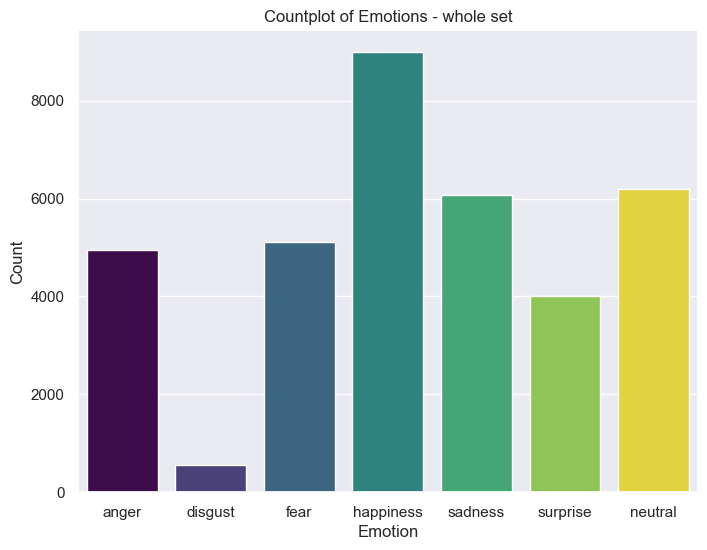

In [13]:
utils.plot_emotion_count(df, emotions_dict, "whole set")

## Plot the images with the corresponding labels

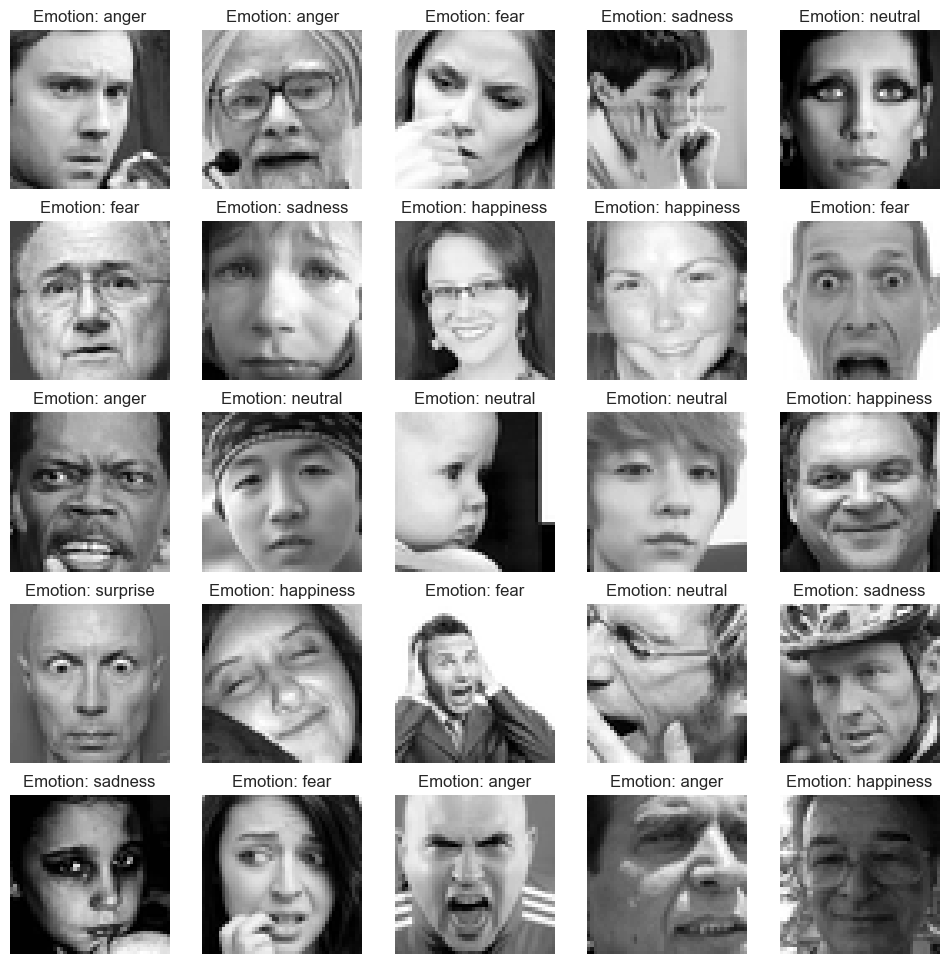

In [14]:
utils.show_images(df, emotions_dict, num_images=25, num_cols=5)

## Split the data into train, validation and test

In [15]:
# Split the dataset based on the "Usage" column
train_df = df[df['Usage'] == 'Training']
public_test_df = df[df['Usage'] == 'PublicTest']
private_test_df = df[df['Usage'] == 'PrivateTest']

In [16]:
# Print the lengths of the sets
print(f"Training set length: {len(train_df)}")
print(f"Public Test set set length: {len(public_test_df)}")
print(f"Private Test set length: {len(private_test_df)}")   

Training set length: 28709
Public Test set set length: 3589
Private Test set length: 3589


## Plot label occurence for all individual sets

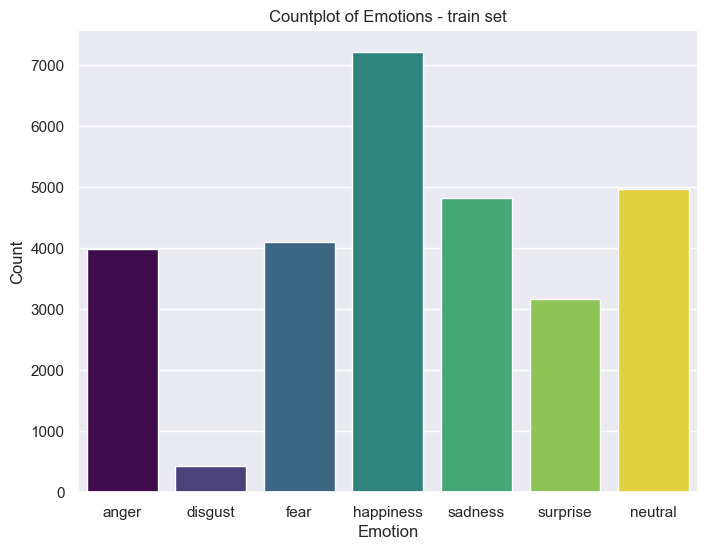

In [17]:
utils.plot_emotion_count(train_df, emotions_dict, "train set")

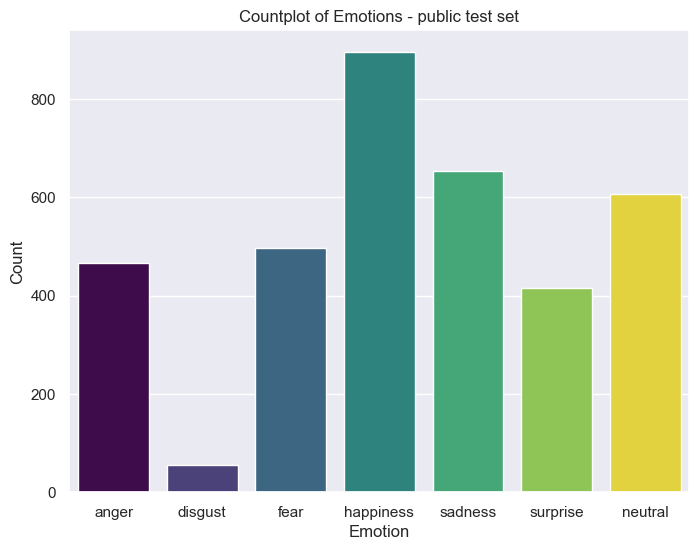

In [18]:
utils.plot_emotion_count(public_test_df, emotions_dict, "public test set")

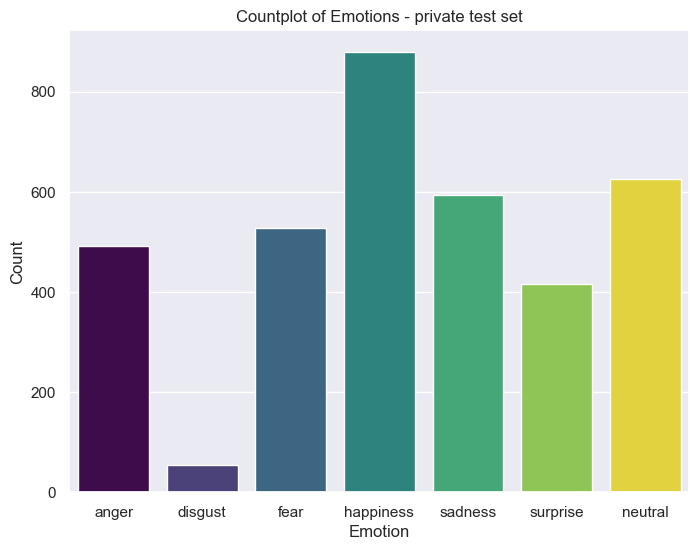

In [19]:
utils.plot_emotion_count(private_test_df, emotions_dict, "private test set")

## Split the sets into data and labels

In [20]:
train_labels, train_data = utils.split_labels_and_data(train_df)
public_test_labels, public_test_data = utils.split_labels_and_data(public_test_df)
private_test_labels, private_test_data = utils.split_labels_and_data(private_test_df)

In [21]:
# some more preprocessing of the data
train_data = utils.convert_string_to_int_array(train_data)
public_test_data = utils.convert_string_to_int_array(public_test_data)
private_test_data = utils.convert_string_to_int_array(private_test_data)

In [22]:
train_labels = train_labels.values
public_test_labels = public_test_labels.values
private_test_labels = private_test_labels.values

In [23]:
print(len(train_data))

28709


## Create a custom dataset class

In [24]:
from torch.utils.data import Dataset, DataLoader, random_split
import math

In [25]:
train_dataset = utils.CustomDataset(train_data, train_labels)
public_test_set = utils.CustomDataset(public_test_data, public_test_labels)
private_test_set = utils.CustomDataset(private_test_data, private_test_labels)

# split further into train and validation set
validation_set_fraction = 0.15
train_set_length = math.floor(len(train_dataset) * (1-validation_set_fraction))
validation_set_length = math.ceil(len(train_dataset) * (validation_set_fraction))

# train validation split
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_length, validation_set_length])

# Simple CNN for first tests

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(9216, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [27]:
# set up cude if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set up Dataloaders

In [28]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 1

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a RandomSampler with random indices
random_sampler = RandomSampler(data_source=train_set, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 512

train_dataloader = DataLoader(train_set, batch_size, sampler=random_sampler)
valid_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
public_test_dataloader = DataLoader(public_test_set, batch_size=batch_size, shuffle=False)
private_test_dataloader = DataLoader(private_test_set, batch_size=batch_size, shuffle=False)

In [29]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

## Training

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.tensorboard import SummaryWriter

# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_simple_model.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_simple_CNN", comment='SimpleCNN')

# Initialize model, loss function, optimizer
model = SimpleCNN()
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 1, 48, 48).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15
# Start the training loop

#utils.train(train_dataloader, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

## Test model (classification report, confusion matrix and misclassified images)

In [31]:
# Create an instance of the model
model = SimpleCNN()

# Load the saved model state dictionary
model.load_state_dict(torch.load('models/best_simple_model.pth'))

<All keys matched successfully>

In [32]:
model

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
)

## Test on Public Test set

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger       0.47      0.22      0.30       467
     disgust       0.62      0.09      0.16        56
        fear       0.35      0.28      0.31       496
   happiness       0.64      0.76      0.70       895
     sadness       0.38      0.47      0.42       653
    surprise       0.59      0.70      0.64       415
     neutral       0.46      0.45      0.46       607

    accuracy                           0.50      3589
   macro avg       0.50      0.43      0.43      3589
weighted avg       0.49      0.50      0.49      3589





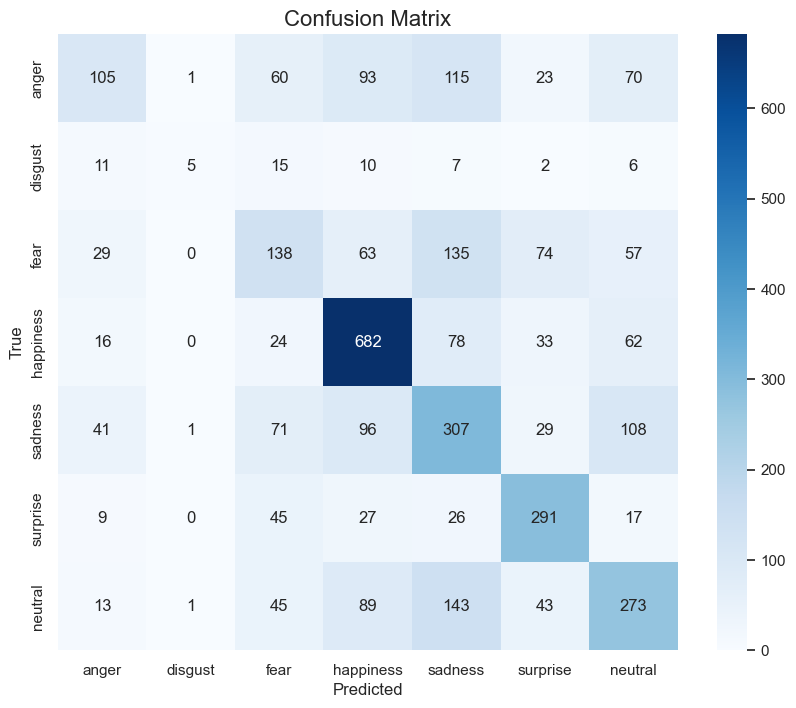



Misclassified Images: 



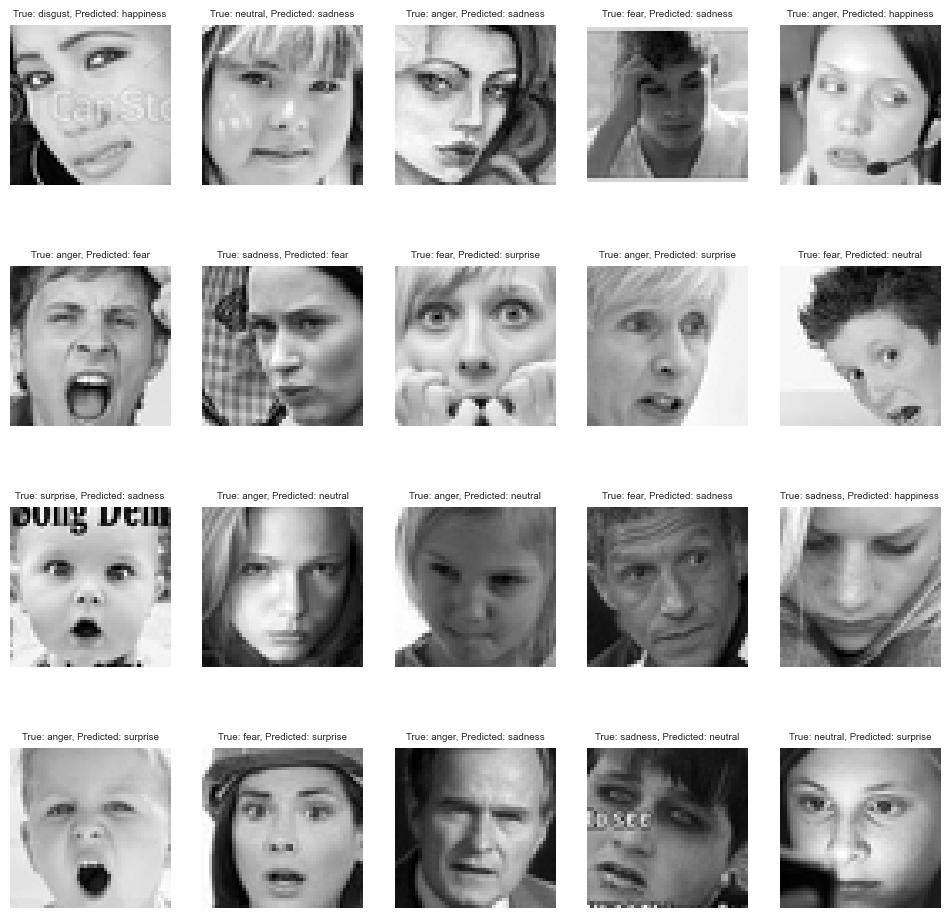

In [33]:
utils.test(model, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

## Test on Private Test set

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger       0.48      0.23      0.31       491
     disgust       0.50      0.09      0.15        55
        fear       0.33      0.27      0.30       528
   happiness       0.63      0.78      0.70       879
     sadness       0.35      0.44      0.39       594
    surprise       0.58      0.68      0.63       416
     neutral       0.51      0.47      0.49       626

    accuracy                           0.50      3589
   macro avg       0.48      0.42      0.42      3589
weighted avg       0.49      0.50      0.48      3589





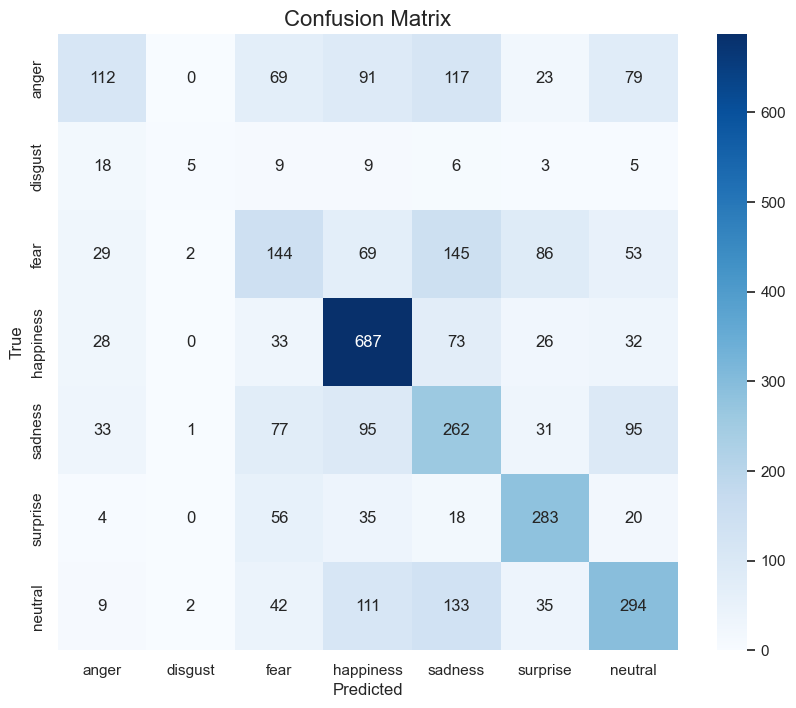



Misclassified Images: 



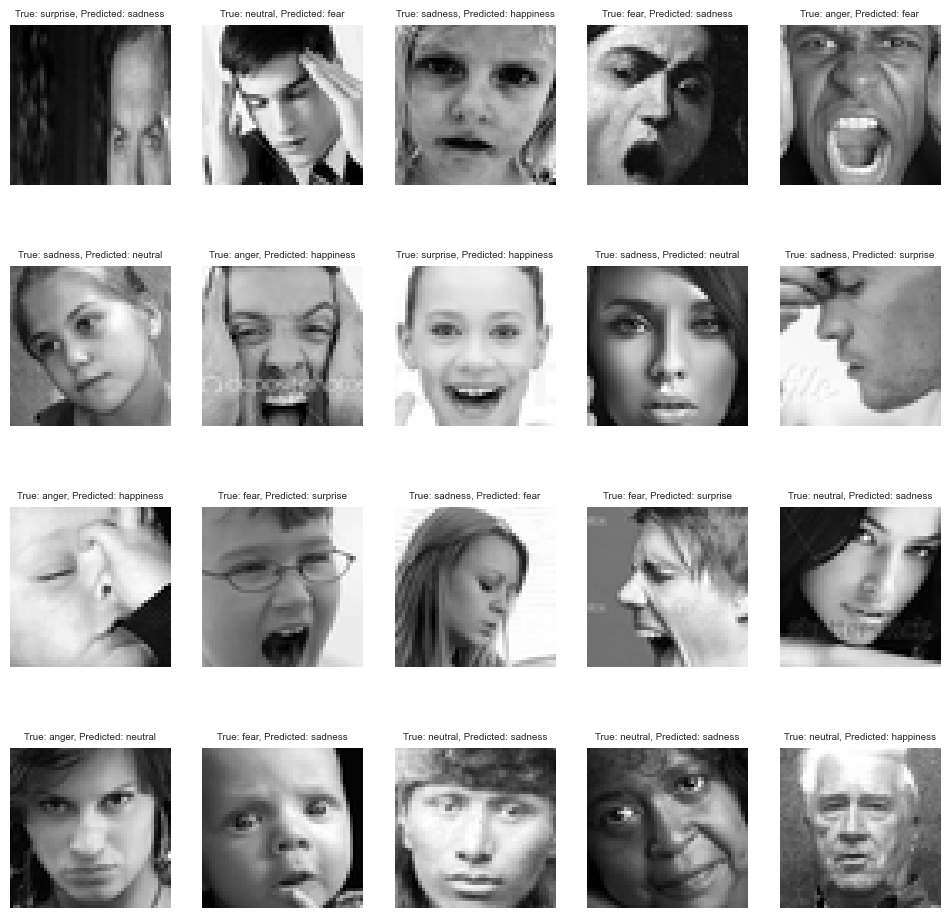

In [34]:
utils.test(model, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

## Resample the training data

In [35]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 1

# get the train_sample_weights
train_sample_weights = utils.get_datapoint_weights(train_set)

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a WeightedRandomSampler with random indices
weighted_random_sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 512

upsampled_train_dataloader = DataLoader(train_set, batch_size, sampler=weighted_random_sampler)

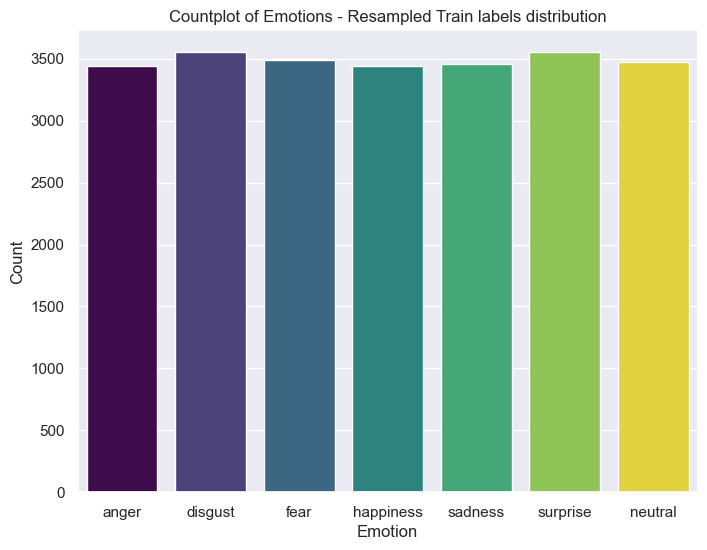

In [36]:
utils.plot_emotion_count(upsampled_train_dataloader, emotions_dict, "Resampled Train labels distribution")

## Training

In [37]:
# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_simple_model_resampled.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_simple_CNN_resampled", comment='SimpleCNN_resampled')

# Initialize model, loss function, optimizer
model = SimpleCNN()
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 1, 48, 48).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15
# Start the training loop

#utils.train(upsampled_train_dataloader, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

## Test model (classification report, confusion matrix and misclassified images)

In [38]:
# Create an instance of the model
model = SimpleCNN()

# Load the saved model state dictionary
model.load_state_dict(torch.load('models/best_simple_model_resampled.pth'))

<All keys matched successfully>

## Test on Public Testset

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger       0.43      0.34      0.38       467
     disgust       0.55      0.52      0.53        56
        fear       0.40      0.27      0.33       496
   happiness       0.73      0.66      0.70       895
     sadness       0.38      0.49      0.43       653
    surprise       0.68      0.67      0.68       415
     neutral       0.43      0.54      0.48       607

    accuracy                           0.51      3589
   macro avg       0.51      0.50      0.50      3589
weighted avg       0.52      0.51      0.51      3589





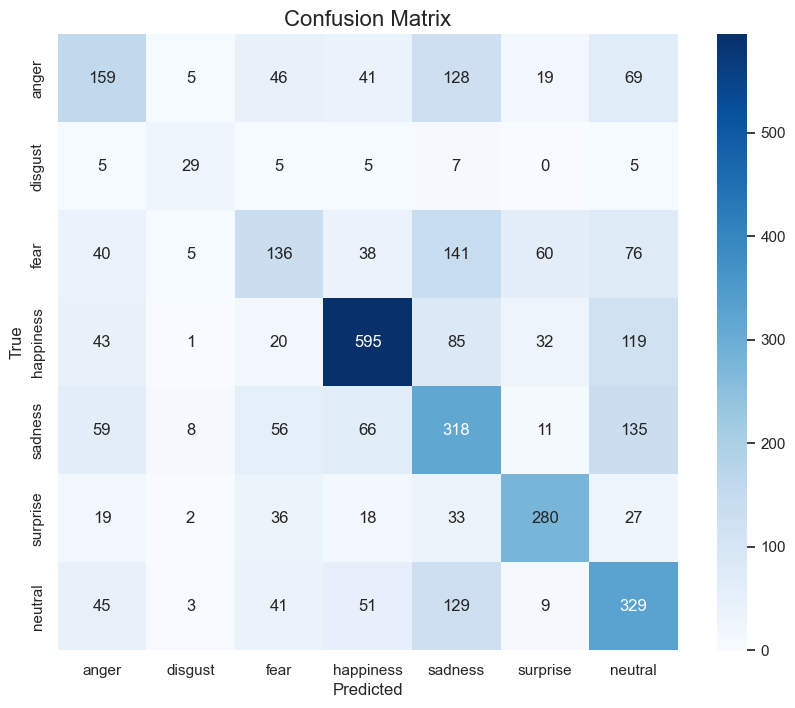



Misclassified Images: 



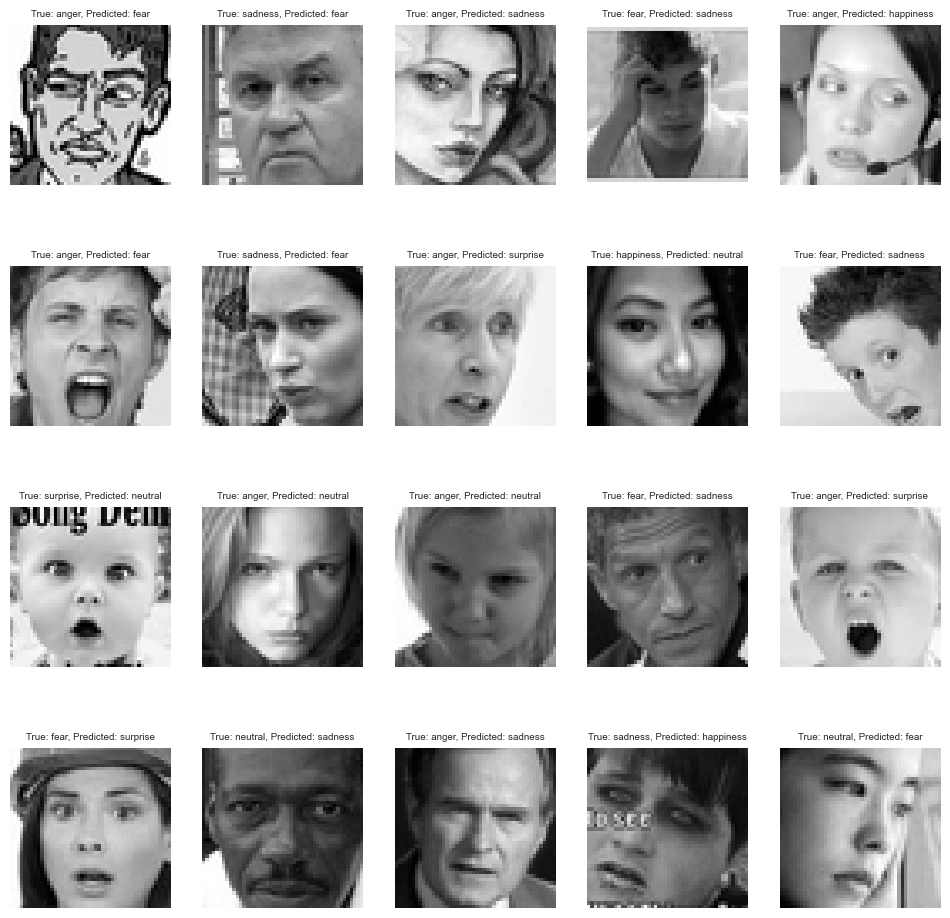

In [39]:
utils.test(model, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

## Test on Private Test set

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger       0.43      0.33      0.37       491
     disgust       0.51      0.55      0.53        55
        fear       0.40      0.30      0.34       528
   happiness       0.74      0.68      0.70       879
     sadness       0.36      0.49      0.41       594
    surprise       0.69      0.65      0.67       416
     neutral       0.47      0.56      0.51       626

    accuracy                           0.52      3589
   macro avg       0.51      0.51      0.51      3589
weighted avg       0.53      0.52      0.52      3589





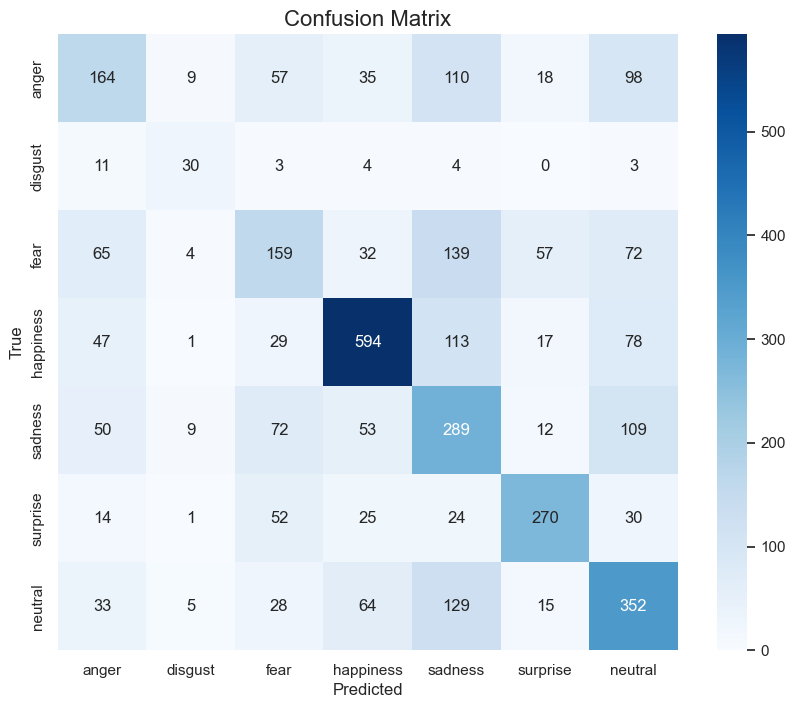



Misclassified Images: 



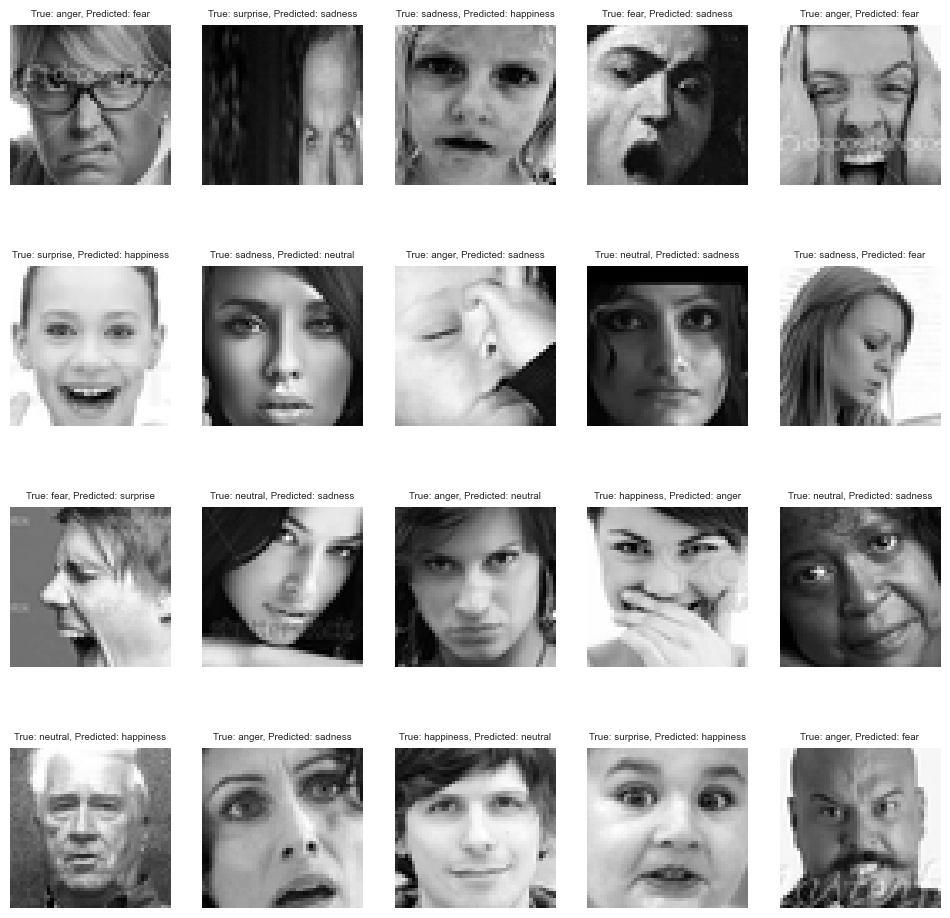

In [40]:
utils.test(model, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

Resampling did not lead to better accuracy!

## Data augmentation

In [41]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Subset

# Define the transformations 
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(48, 48), scale=(0.8, 1.2), ratio=(0.9, 1.1)),
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1), shear=5),
    transforms.ToTensor()
])

# Create augmented subsets with transformations
train_set_augmented = utils.CustomDataset(train_data, train_labels, train_transform)

In [42]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 1

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set_augmented) * train_set_sample_fraction)

# number of samples
n_samples = int(len(train_set_augmented)*train_set_sample_fraction)

# Use a RandomSampler with random indices
random_sampler = RandomSampler(data_source=train_set_augmented, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 512

train_dataloader_augmented = DataLoader(train_set_augmented, batch_size, sampler=random_sampler)
valid_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
public_test_dataloader = DataLoader(public_test_set, batch_size=batch_size, shuffle=False)
private_test_dataloader = DataLoader(private_test_set, batch_size=batch_size, shuffle=False)

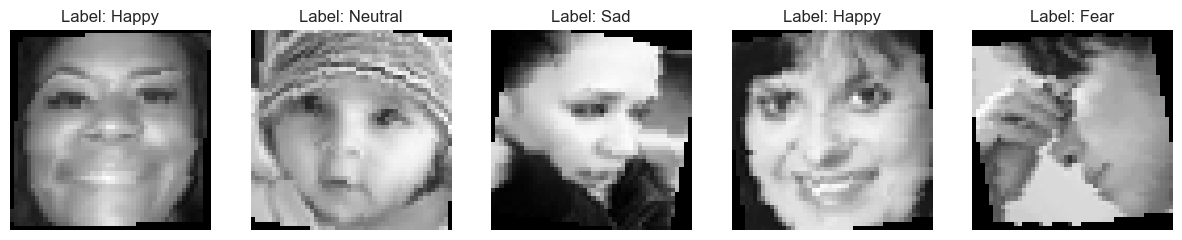

In [43]:
def plot_batch_images(images, labels, k=5):
    """
    Plot the first "k" original and augmented images from a batch.

    Parameters:
    - images (torch.Tensor): The batch of images.
    - labels (torch.Tensor): The corresponding labels.
    - k (int): Number of pairs of images to plot.

    Returns:
    None
    """

    label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    
    fig, axes = plt.subplots(1, k, figsize=(15, 6))

    for i in range(k):
        # Get the i-th original image from the batch
        image = images[i].squeeze().numpy()

        # Plot original image
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label_dict[labels[i].item()]}")
        axes[i].axis('off')
    plt.show()

# Example usage
for batch in train_dataloader_augmented:
    images, labels = batch
    plot_batch_images(images, labels, k=5)
    break

In [44]:
# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_simple_model_augmented.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_simple_CNN_augmented", comment='SimpleCNN_augmented')

# Initialize model, loss function, optimizer
model = SimpleCNN()
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 1, 48, 48).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader_augmented, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [45]:
## Test model (classification report, confusion matrix and misclassified images)

In [46]:
# Create an instance of the model
model = SimpleCNN()

# Load the saved model state dictionary
model.load_state_dict(torch.load('models/best_simple_model_augmented.pth'))

<All keys matched successfully>

In [47]:
# Public Test set

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger       0.51      0.47      0.49       467
     disgust       0.88      0.54      0.67        56
        fear       0.45      0.41      0.43       496
   happiness       0.79      0.78      0.78       895
     sadness       0.48      0.44      0.46       653
    surprise       0.69      0.79      0.74       415
     neutral       0.50      0.59      0.54       607

    accuracy                           0.59      3589
   macro avg       0.62      0.57      0.59      3589
weighted avg       0.59      0.59      0.59      3589





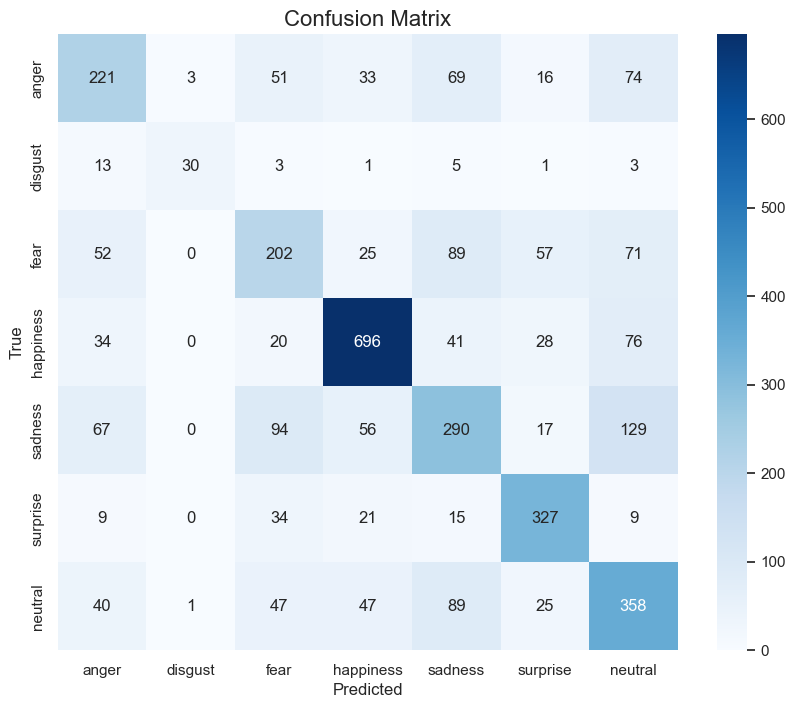



Misclassified Images: 



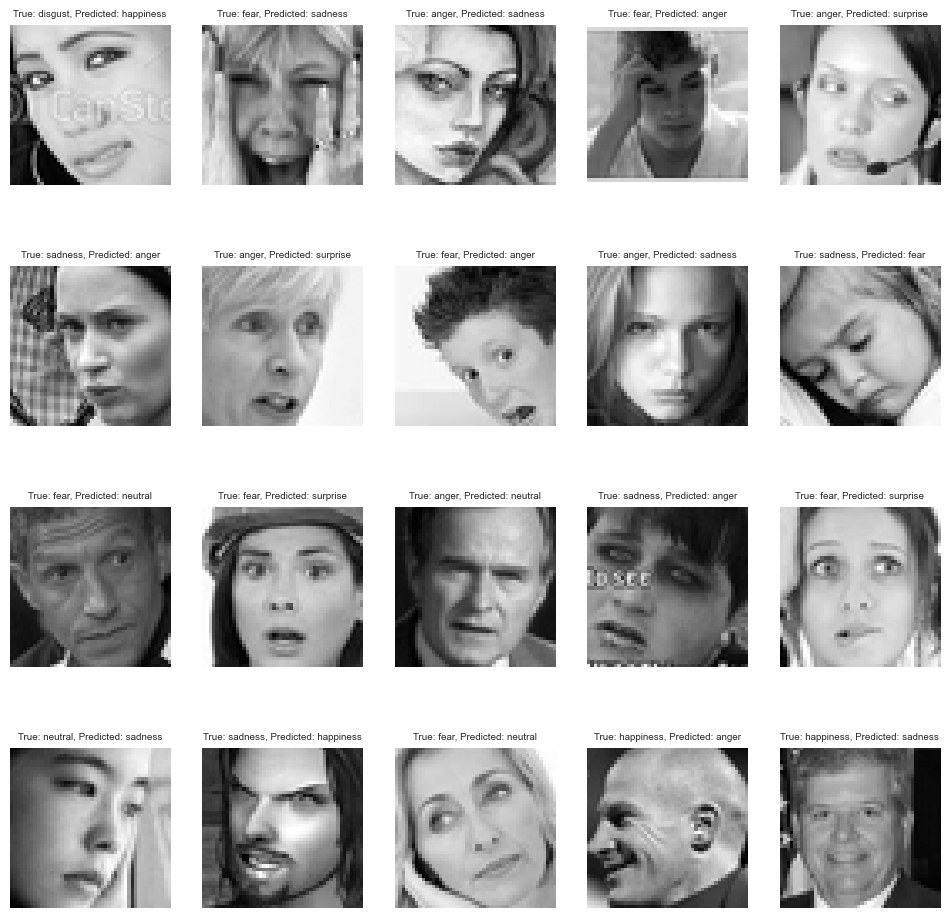

In [48]:
utils.test(model, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

In [49]:
## Private Test set

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger       0.52      0.46      0.49       491
     disgust       0.79      0.60      0.68        55
        fear       0.47      0.42      0.44       528
   happiness       0.81      0.78      0.80       879
     sadness       0.47      0.45      0.46       594
    surprise       0.74      0.80      0.77       416
     neutral       0.53      0.64      0.58       626

    accuracy                           0.61      3589
   macro avg       0.62      0.59      0.60      3589
weighted avg       0.61      0.61      0.60      3589





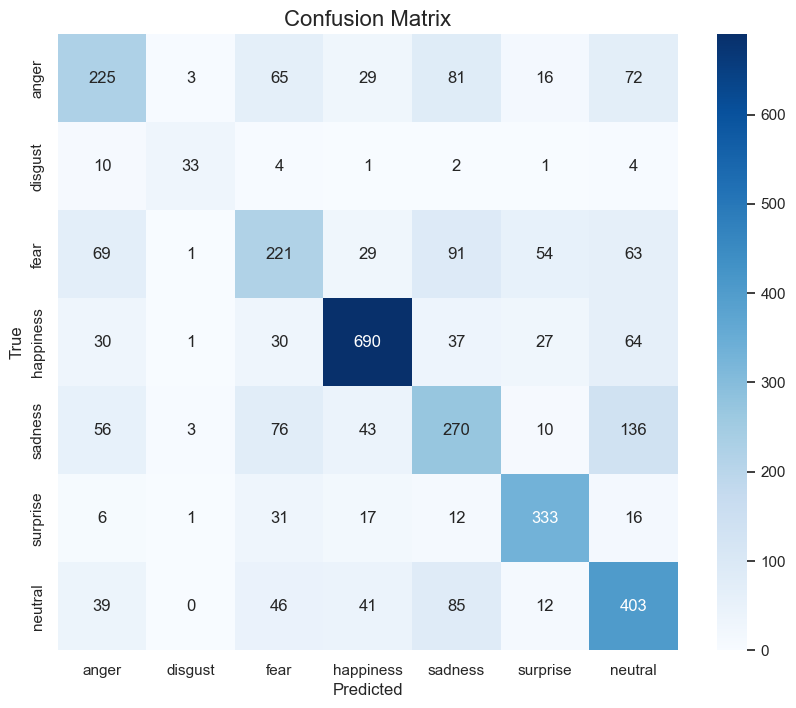



Misclassified Images: 



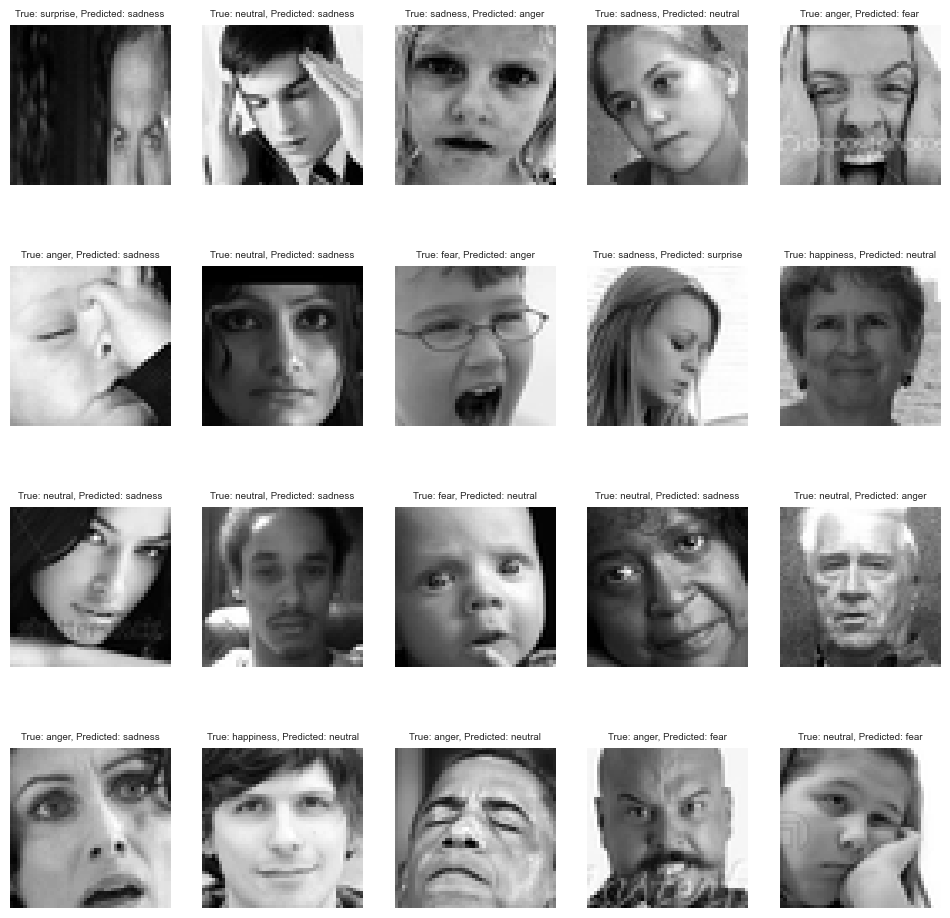

In [50]:
utils.test(model, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

# Augmentation with upsampling

In [51]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 1

# get the train_sample_weights
train_sample_weights = utils.get_datapoint_weights(train_set)

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a WeightedRandomSampler with random indices
weighted_random_sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 512

upsampled_train_dataloader_augmented = DataLoader(train_set_augmented, batch_size, sampler=weighted_random_sampler)

In [52]:
# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_simple_model_augmented_upsampled.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_simple_CNN_augmented_upsampled", comment='SimpleCNN_augmented_upsampled')

# Initialize model, loss function, optimizer
model = SimpleCNN()
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 1, 48, 48).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(upsampled_train_dataloader_augmented, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [53]:
# Create an instance of the model
model = SimpleCNN()

# Load the saved model state dictionary
model.load_state_dict(torch.load('models/best_simple_model_augmented_upsampled.pth'))

<All keys matched successfully>

In [54]:
for i in public_test_dataloader:

    print(i[0].shape)
    break

torch.Size([512, 1, 48, 48])


Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger       0.48      0.48      0.48       467
     disgust       0.74      0.45      0.56        56
        fear       0.47      0.43      0.45       496
   happiness       0.77      0.80      0.79       895
     sadness       0.47      0.47      0.47       653
    surprise       0.74      0.75      0.74       415
     neutral       0.51      0.54      0.52       607

    accuracy                           0.59      3589
   macro avg       0.60      0.56      0.57      3589
weighted avg       0.59      0.59      0.59      3589





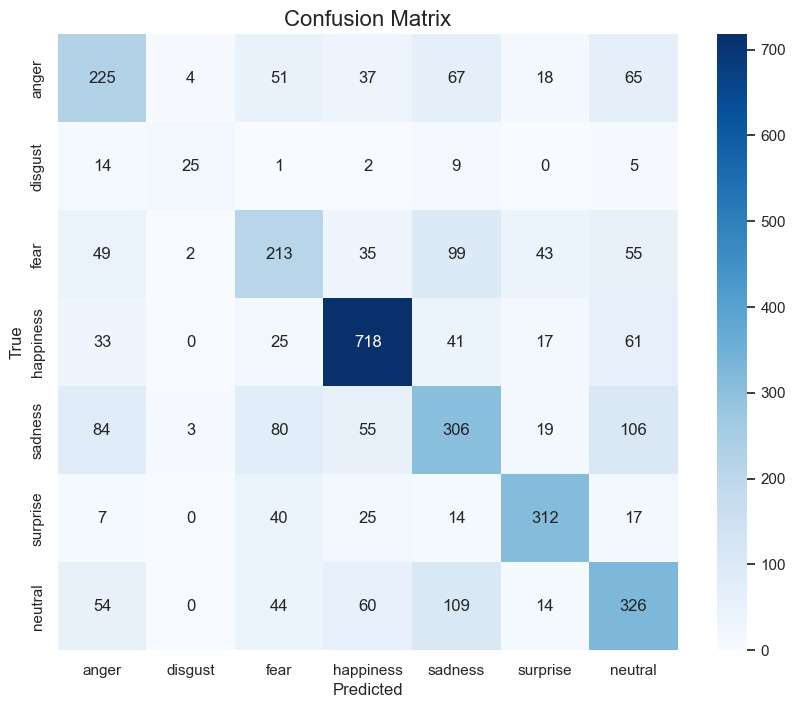



Misclassified Images: 



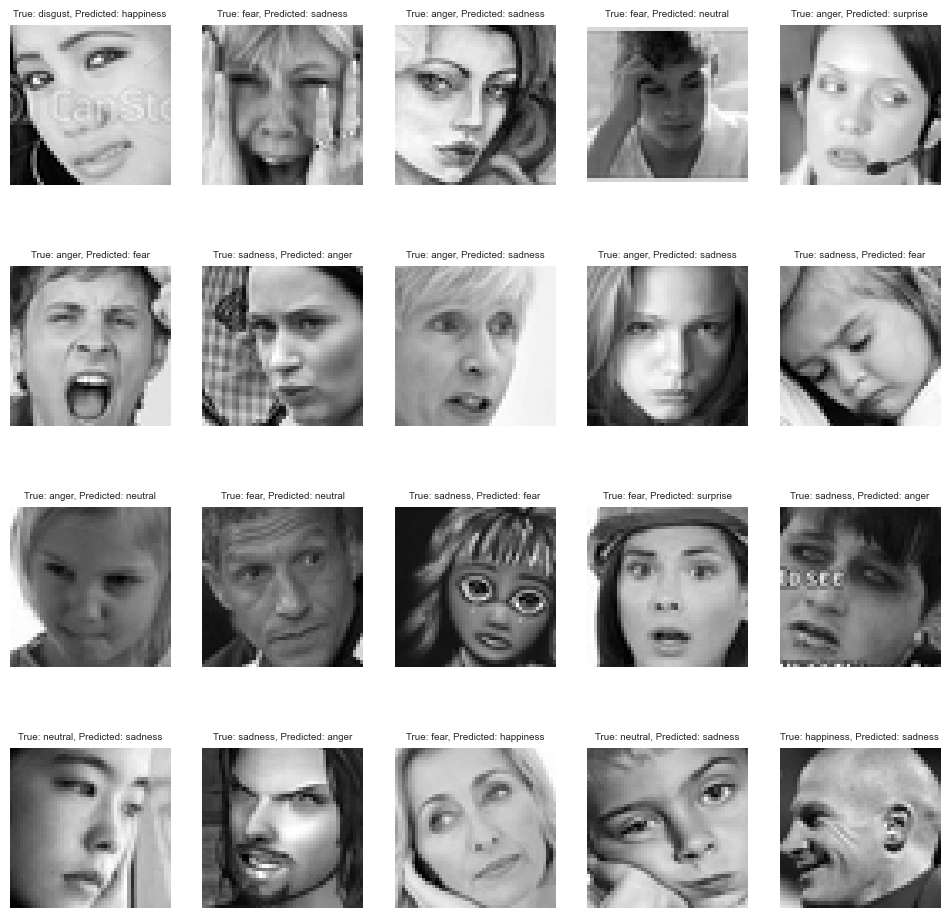

In [55]:
utils.test(model, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger       0.48      0.48      0.48       491
     disgust       0.62      0.45      0.53        55
        fear       0.47      0.44      0.46       528
   happiness       0.77      0.80      0.79       879
     sadness       0.44      0.47      0.46       594
    surprise       0.74      0.69      0.71       416
     neutral       0.57      0.58      0.57       626

    accuracy                           0.59      3589
   macro avg       0.59      0.56      0.57      3589
weighted avg       0.59      0.59      0.59      3589





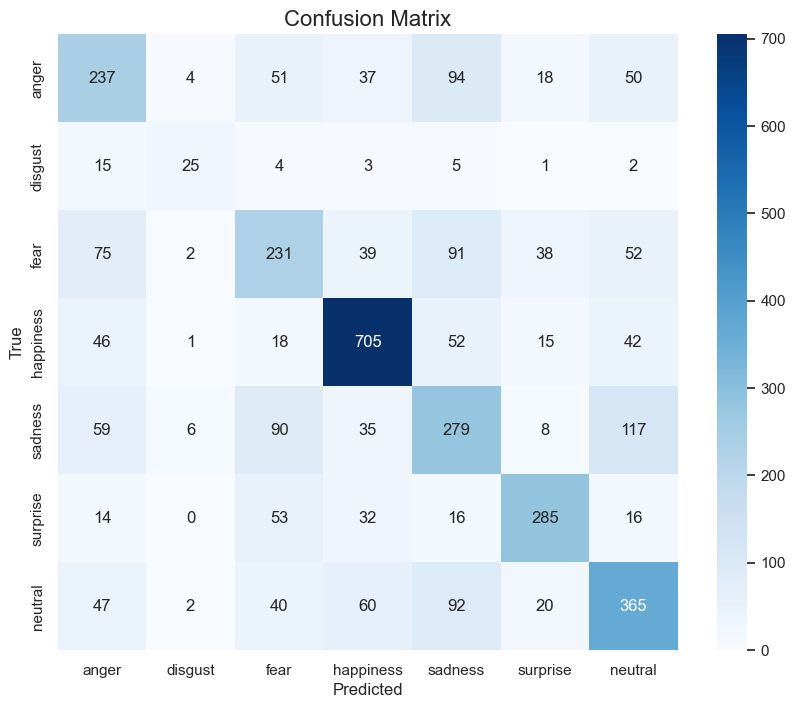



Misclassified Images: 



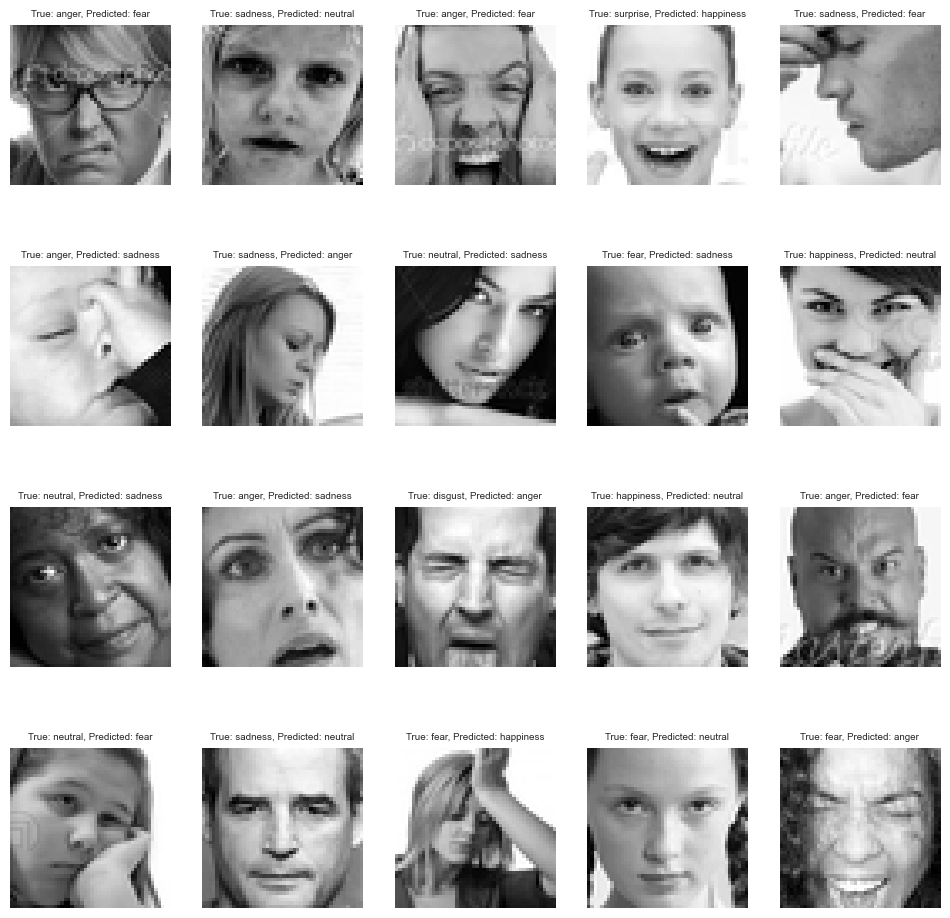

In [56]:
utils.test(model, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

In [57]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 173012), started 0:00:34 ago. (Use '!kill 173012' to kill it.)

# Same code just with a learning rate scheduler

In [58]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [71]:
# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_simple_model_augmented_scheduler.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_simple_CNN_augmented_scheduler", comment='SimpleCNN_augmented_scheduler')

# Initialize model, loss function, optimizer
model = SimpleCNN()
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 1, 48, 48).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# lr scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# early stopping
patience = 15

# Start the training loop
utils.train(train_dataloader_augmented, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, patience, scheduler)

Initial Stats: 



Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.9546, Train Accuracy: 0.1759
Validation Loss: 1.9546, Validation Accuracy: 0.1753
--------------------------------------------------

Starting training: 



Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/250 ==> Train Loss: 1.5821, Train Accuracy: 0.3804 Validation Loss: 1.5020, Validation Accuracy: 0.4168


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/250 ==> Train Loss: 1.4344, Train Accuracy: 0.4448 Validation Loss: 1.3406, Validation Accuracy: 0.4883


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/250 ==> Train Loss: 1.3392, Train Accuracy: 0.4841 Validation Loss: 1.2422, Validation Accuracy: 0.5289


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/250 ==> Train Loss: 1.2769, Train Accuracy: 0.5095 Validation Loss: 1.2222, Validation Accuracy: 0.5347


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/250 ==> Train Loss: 1.2133, Train Accuracy: 0.5378 Validation Loss: 1.1199, Validation Accuracy: 0.5805


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/250 ==> Train Loss: 1.1821, Train Accuracy: 0.5522 Validation Loss: 1.0796, Validation Accuracy: 0.5995


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/250 ==> Train Loss: 1.1261, Train Accuracy: 0.5753 Validation Loss: 1.0139, Validation Accuracy: 0.6174


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/250 ==> Train Loss: 1.1016, Train Accuracy: 0.5826 Validation Loss: 0.9756, Validation Accuracy: 0.6329


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/250 ==> Train Loss: 1.0701, Train Accuracy: 0.5964 Validation Loss: 0.9570, Validation Accuracy: 0.6422


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/250 ==> Train Loss: 1.0258, Train Accuracy: 0.6173 Validation Loss: 0.8816, Validation Accuracy: 0.6743


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55/250 ==> Train Loss: 1.0142, Train Accuracy: 0.6199 Validation Loss: 0.8317, Validation Accuracy: 0.6940


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60/250 ==> Train Loss: 0.9766, Train Accuracy: 0.6323 Validation Loss: 0.8316, Validation Accuracy: 0.6956


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65/250 ==> Train Loss: 0.9646, Train Accuracy: 0.6387 Validation Loss: 0.8180, Validation Accuracy: 0.6993


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70/250 ==> Train Loss: 0.9406, Train Accuracy: 0.6464 Validation Loss: 0.7283, Validation Accuracy: 0.7325


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75/250 ==> Train Loss: 0.9207, Train Accuracy: 0.6542 Validation Loss: 0.7234, Validation Accuracy: 0.7379


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 80/250 ==> Train Loss: 0.9010, Train Accuracy: 0.6646 Validation Loss: 0.6809, Validation Accuracy: 0.7499


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 85/250 ==> Train Loss: 0.8671, Train Accuracy: 0.6790 Validation Loss: 0.6677, Validation Accuracy: 0.7595


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 90/250 ==> Train Loss: 0.8491, Train Accuracy: 0.6857 Validation Loss: 0.6302, Validation Accuracy: 0.7701


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 95/250 ==> Train Loss: 0.8309, Train Accuracy: 0.6908 Validation Loss: 0.6443, Validation Accuracy: 0.7588


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 100/250 ==> Train Loss: 0.8197, Train Accuracy: 0.6950 Validation Loss: 0.5783, Validation Accuracy: 0.7855


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 105/250 ==> Train Loss: 0.8038, Train Accuracy: 0.7031 Validation Loss: 0.5947, Validation Accuracy: 0.7857


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 110/250 ==> Train Loss: 0.7760, Train Accuracy: 0.7142 Validation Loss: 0.5704, Validation Accuracy: 0.7936


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 115/250 ==> Train Loss: 0.7801, Train Accuracy: 0.7122 Validation Loss: 0.5287, Validation Accuracy: 0.8108


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 120/250 ==> Train Loss: 0.7569, Train Accuracy: 0.7212 Validation Loss: 0.5226, Validation Accuracy: 0.8140


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 00123: reducing learning rate of group 0 to 1.0000e-04.


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 125/250 ==> Train Loss: 0.7044, Train Accuracy: 0.7433 Validation Loss: 0.4706, Validation Accuracy: 0.8293


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 130/250 ==> Train Loss: 0.6883, Train Accuracy: 0.7496 Validation Loss: 0.4480, Validation Accuracy: 0.8419


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 135/250 ==> Train Loss: 0.6856, Train Accuracy: 0.7483 Validation Loss: 0.4443, Validation Accuracy: 0.8412


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 140/250 ==> Train Loss: 0.6711, Train Accuracy: 0.7557 Validation Loss: 0.4350, Validation Accuracy: 0.8433


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 00143: reducing learning rate of group 0 to 1.0000e-05.


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 145/250 ==> Train Loss: 0.6624, Train Accuracy: 0.7568 Validation Loss: 0.4302, Validation Accuracy: 0.8463


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 150/250 ==> Train Loss: 0.6779, Train Accuracy: 0.7545 Validation Loss: 0.4304, Validation Accuracy: 0.8456


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 155/250 ==> Train Loss: 0.6678, Train Accuracy: 0.7560 Validation Loss: 0.4282, Validation Accuracy: 0.8479


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 160/250 ==> Train Loss: 0.6692, Train Accuracy: 0.7563 Validation Loss: 0.4306, Validation Accuracy: 0.8475


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 00164: reducing learning rate of group 0 to 1.0000e-06.


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 165/250 ==> Train Loss: 0.6644, Train Accuracy: 0.7580 Validation Loss: 0.4284, Validation Accuracy: 0.8477


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 00170: reducing learning rate of group 0 to 1.0000e-07.
Epoch 170/250 ==> Train Loss: 0.6562, Train Accuracy: 0.7605 Validation Loss: 0.4279, Validation Accuracy: 0.8479


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

No improvement for 15 consecutive epochs. Stopping training.


# Use Advanced Model (ConvNeXt Tiny)
https://pytorch.org/vision/main/models/generated/torchvision.models.convnext_tiny.html#torchvision.models.convnext_tiny

In [60]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

convnext_tiny = torchvision.models.convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)

In [61]:
convnext_tiny

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [62]:
in_features = 768  # Number of features of the classifier
out_features = 7  # Number of output classes

# Modify the final fully connected layer for the specified number of classes
convnext_tiny.classifier[-1] = nn.Linear(in_features, out_features, bias=True)

# Print the modified model architecture
print(convnext_tiny)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [63]:
from torchvision import transforms
from PIL import Image

# Define the transformations for ConvNeXt model
resize_size = [230]
crop_size = [224]
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(resize_size, interpolation=Image.BILINEAR),
    transforms.CenterCrop(crop_size),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean, std=normalize_std)
])

train_dataset = utils.CustomDataset(train_data, train_labels, transform=transform)
public_test_set = utils.CustomDataset(public_test_data, public_test_labels, transform=transform)
private_test_set = utils.CustomDataset(private_test_data, private_test_labels, transform=transform)

# split further into train and validation set
validation_set_fraction = 0.15
train_set_length = math.floor(len(train_dataset) * (1-validation_set_fraction))
validation_set_length = math.ceil(len(train_dataset) * (validation_set_fraction))

# train validation split
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_length, validation_set_length])

## Set Up Dataloaders again

In [64]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 0.1

# get the train_sample_weights
train_sample_weights = utils.get_datapoint_weights(train_set)

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a WeightedRandomSampler with random indices
weighted_random_sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 16

#train_dataloader = DataLoader(train_set, batch_size, sampler=weighted_random_sampler)
#valid_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
#public_test_dataloader = DataLoader(public_test_set, batch_size=batch_size, shuffle=False)
#private_test_dataloader = DataLoader(private_test_set, batch_size=batch_size, shuffle=False)

In [65]:
#utils.plot_emotion_count(train_dataloader, emotions_dict, "Resampled Train labels distribution")

In [66]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 173012), started 0:01:03 ago. (Use '!kill 173012' to kill it.)

In [67]:
# set up some hyperparams and saving paths
learning_rate = 0.0001
save_path = 'models/best_ConvNext_model.pth'
epochs = 30
writer = SummaryWriter(log_dir="runs/experiment_ConvNext", comment='ConvNext')

# Initialize model, loss function, optimizer
model = convnext_tiny
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# Start the training loop
#utils.train(train_dataloader, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler)

## Test model (classification report, confusion matrix and misclassified images)

In [68]:
# Create an instance of the model
#model = convnext_tiny

# Load the saved model state dictionary
#model.load_state_dict(torch.load('models/best_ConvNext_model.pth'))#

## Test on Public Test Set

In [69]:
# Assuming your model, test_dataloader, and device are defined
#utils.test(model, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

## Test on Private Test Set

In [70]:
#utils.test(model, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

# Advanced CNN using augmentation, hyperparameter search

### TODO: data augmentation, learning_rate, scheduler, early stopping, weight decay